# Dependency

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras tools
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from keras.callbacks import ModelCheckpoint

np.random.seed(42)
keras.backend.clear_session()
keras.utils.set_random_seed(42)

!nvidia-smi


Mon Jun 10 10:48:00 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 474.64       Driver Version: 474.64       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0 N/A |                  N/A |
| 40%    0C    P8    N/A /  N/A |    566MiB /  2048MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+------

# Load data

In [3]:
data = pd.read_csv("dataset/merged_cleaned_data.csv")
data.columns

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctsomecol18_24',
       'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over',
       'pctemployed16_over', 'pctunemployed16_over', 'pctprivatecoverage',
       'pctprivatecoveragealone', 'pctempprivcoverage', 'pctpubliccoverage',
       'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian',
       'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'statefips',
       'countyfips', 'avghouseholdsize', 'mean_private_coverage',
       'expected_private_coverage'],
      dtype='object')

### Create features

Normalize the death_rate, target_death_rate and diagnosis_rate

In [4]:
data['death_rate_per_1000'] = data['avgdeathsperyear'] / data['popest2015'] * 1000
data['target_death_rate_per_1000'] = data['target_deathrate'] / data['popest2015'] * 1000
data['diagnosis_rate_per_1000'] = data['avganncount'] / data['popest2015'] * 1000
data['diagnosis_rate_against_incidence'] = data['avganncount'] / data['incidencerate']

data['distance_from_target'] = data['target_death_rate_per_1000'] - data['death_rate_per_1000'] 
data['mortality_from_diag'] = data['avgdeathsperyear']/ data['avganncount'] 

data['insurance_gap'] = data['pctprivatecoverage'] - data['pctpubliccoverage']

In [5]:
data.drop(['avgdeathsperyear', 'popest2015', 'target_deathrate', 'avganncount', 'mean_private_coverage',
       'expected_private_coverage'], axis=1, inplace=True)

In [6]:
# List of features to exclude to prevent data leakage
features_to_exclude = [
    'death_rate_per_1000', 
    'target_death_rate_per_1000',  # Directly related to target
    'distance_from_target',        # Derived from target
    'mortality_from_diag'          # Directly measures outcome similar to target
]

features = [
    'pctunemployed16_over',  # Existing feature
    'pctpubliccoverage',     # Existing feature
    'pctprivatecoverage',    # Existing feature
    'medincome',             # Existing feature
    'povertypercent',        # Existing feature
    'medianagefemale',       # Highly correlated
    'medianagemale',         # Highly correlated
    'avghouseholdsize',      # Highly correlated
    'pcths25_over',          # Highly correlated
    'pctbachdeg25_over',     # Highly correlated
    'pctempprivcoverage',    # Highly correlated
    'insurance_gap',         # Derived feature showing difference in coverages
    'pctprivatecoveragealone',  # Highly correlated
    'pctemployed16_over',    # Moderately correlated
    'pctpubliccoveragealone' # Coverage feature
    # Consider adding or removing features based on model performance and domain knowledge
]


In [7]:
data.loc[:, ["death_rate_per_1000", "target_death_rate_per_1000"]]

,death_rate_per_1000,target_death_rate_per_1000
0,1.802938,0.633911
1,1.617786,3.727842
2,2.378008,8.308761
3,2.662028,2.567144
4,2.519136,13.990892
...,...,...
3042,2.364812,23.585054
3043,1.158468,4.043860
3044,1.331943,4.456220
3045,2.030536,6.833535


# Build model predict death rate

In [17]:
X = data[features]
predict_features = 'death_rate_per_1000'
y = data[predict_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

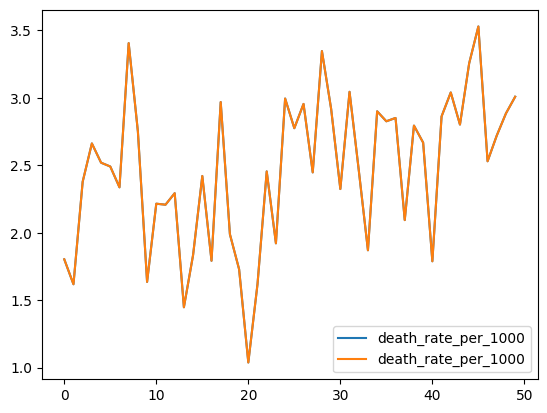

In [18]:
y[0:50].plot()
data["death_rate_per_1000"][0:50].plot()
plt.legend()

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
X_train

array([[ 0.64696324,  1.69938416, -1.07529158, ..., -1.62012714,
        -1.6591249 ,  1.24183413],
       [-1.5897651 ,  0.33384028,  1.20442929, ..., -0.17982587,
         0.66010539, -1.07171642],
       [-0.20652521,  0.84104229,  0.15518538, ..., -0.23180182,
        -0.15409248,  0.37006146],
       ...,
       [-0.70684602, -0.99268806,  1.19489071, ...,  1.45221886,
         1.33860362, -0.92083269],
       [-1.73691828, -0.51149641,  0.98504193, ...,  0.78785341,
         1.03019533, -1.10524614],
       [-0.02994139,  0.385861  ,  0.30780267, ...,  0.17361057,
         0.22319366, -0.04906002]])

In [23]:
model = [
    Input(shape=(15,)),
    Dense(128, kernel_initializer='normal',activation='sigmoid'),
    Dense(128, kernel_initializer='normal',activation='sigmoid'),
    Dropout(rate=0.3),
    Dense(1, activation="linear"),
]
nn = Sequential(model)

# Compile the model
nn.compile(optimizer="adam", loss='mae', metrics=["mse"])

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint("models/" + predict_features + "/" + checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

# Train the model
history = nn.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4470 - mse: 3.1210 - val_loss: 0.4184 - val_mse: 0.2763
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5696 - mse: 0.5182 - val_loss: 0.3196 - val_mse: 0.1780
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4867 - mse: 0.3822 - val_loss: 0.2705 - val_mse: 0.1349
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4641 - mse: 0.3445 - val_loss: 0.2465 - val_mse: 0.1143
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4020 - mse: 0.2732 - val_loss: 0.2390 - val_mse: 0.1092
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3917 - mse: 0.2590 - val_loss: 0.2539 - val_mse: 0.1152
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3858 - mse: 0.2503 - val_loss: 0.2371 - val_mse: 0.1086
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3707 - mse: 0.2358 - val_loss: 0.2329 - val_mse: 0.1050
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.352

In [33]:
keras.utils.clear_session()
nn_sgd = Sequential(model)
nn_sgd.compile(optimizer="sgd", loss='mae', metrics=["mse"])
nn_sgd.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2446 - mse: 0.1121 - val_loss: 0.2220 - val_mse: 0.0974
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2459 - mse: 0.1121 - val_loss: 0.2220 - val_mse: 0.0975
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2416 - mse: 0.1112 - val_loss: 0.2222 - val_mse: 0.0974
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2466 - mse: 0.1144 - val_loss: 0.2221 - val_mse: 0.0976
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2404 - mse: 0.1118 - val_loss: 0.2223 - val_mse: 0.0976
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2448 - mse: 0.1110 - val_loss: 0.2222 - val_mse: 0.0976
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2429 - mse: 0.1104 - val_loss: 0.2221 - val_mse: 0.0975
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2439 - mse: 0.1132 - val_loss: 0.2226 - val_mse: 0.0976
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.246

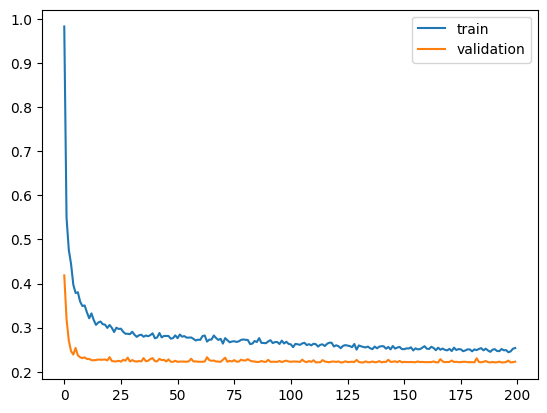

In [34]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig(f"plot/{predict_features}_training_history.png")
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error: 0.10579254043832578
Mean Absolute Error: 0.23123922194493965
R2 Score: 0.7178048031285079


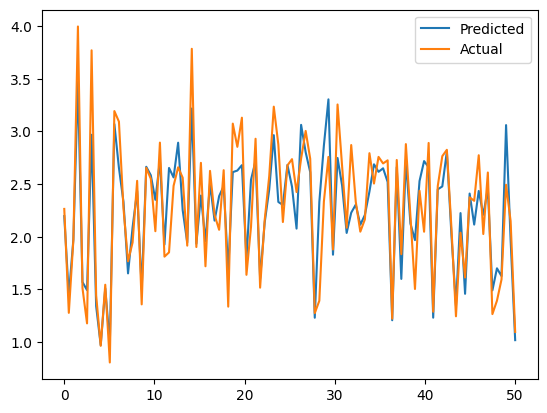

In [35]:
# load the best weight
# nn.load_weights("models/target_death_rate_per_1000/Weights-108--0.06462.keras")

# evaluate the model
y_pred = nn_sgd.predict(X_test)
y_pred = y_pred.reshape(-1)

# calculate the accuracy
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Plot the results
sample = np.linspace(0, 50, 100)
plt.plot(sample, y_pred[0:100])
plt.plot(sample, y_test[0:100])
plt.legend(["Predicted", "Actual"])
plt.savefig(f"plot/{predict_features}_{mae}_{mse}_{r2}.png")
plt.show()

# Random forest

Mean Squared Error: 0.10681474927125231
Mean Absolute Error: 0.23351993109504823
R2 Score: 0.7150781229518498
medianagefemale: 0.5118570590562489
pctpubliccoverage: 0.10540858449860953
medincome: 0.08379026634850166
avghouseholdsize: 0.048699574366582815
medianagemale: 0.048406764356901985
pcths25_over: 0.04321280611431241
pctbachdeg25_over: 0.029309426591868696
pctunemployed16_over: 0.023368751529023225
pctempprivcoverage: 0.017600689429575427
pctemployed16_over: 0.016975162149807734
pctpubliccoveragealone: 0.016377383228622682
povertypercent: 0.01451373925537741
pctprivatecoverage: 0.014161100556723955
pctprivatecoveragealone: 0.013928261178671925
insurance_gap: 0.012390431339171478


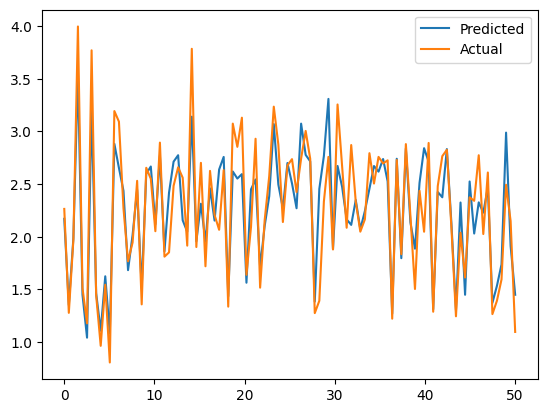

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R2 Score: {r2_rf}")

# Plot the results
sample = np.linspace(0, 50, 100)
plt.plot(sample, y_pred_rf[0:100])
plt.plot(sample, y_test[0:100])
plt.legend(["Predicted", "Actual"])

# Print the feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f"{features[indices[f]]}: {importances[indices[f]]}")
    